# Finetuning Transformer Models for Machine Translation

In the previous assignment, you learned the transformer architecture and trained one from scratch. In this assignment, you will finetune a pre-trained transformer model for machine translation. You will explore dataset preparation, tokenization, model training, and evaluation using the Hugging Face transformers library. The goal is to adapt an existing model to translate between a specific language pair, optimizing its performance on a given dataset. By the end of this assignment, you will have a deeper understanding of transfer learning and how to effectively finetune transformers for NLP tasks using Hugging Face.

For the purpose of this assignment, we will be using the MarianMT transformer model (https://aclanthology.org/P18-4020.pdf) for the English to French translation task. The dataset of sentence pairs has been provided to you.

# 1. Introduction and Setup

For demonstration purposes, we'll use Hugging Face's Transformers library to finetune an English-to-French translation model.

This example requires:
   - transformers
   - datasets
   - sentencepiece

If you are doing this on your local system, you can install them via: !pip install transformers datasets sentencepiece evaluate sacrebleu

This assignment will resemble a real-world coding/finetuning scenario where you will have to constantly look up documentation and use pre-written functions to train a model.

Start by reading about the MarianMTModel and the MarianTokenizer here: https://huggingface.co/docs/transformers/en/model_doc/marian

In [1]:
# 1. Setup and Dependencies
print("1. Setting up dependencies...\n")

# Start by importing the required libraries:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    MarianMTModel,
    MarianTokenizer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from evaluate import load
from sklearn.model_selection import train_test_split
from datetime import datetime

1. Setting up dependencies...



In this section, you'll load and prepare a dataset of English-French sentence pairs for training.

In [2]:
# 2. Data Preparation
print("2. Loading and preparing data...\n")

# Load the dataset
data = pd.read_csv("eng-french.csv")
df = pd.DataFrame(data[0:500])
df.columns = ["en", "fr"]

print("DataFrame of parallel sentences:")
print(df.head())
print(f"Total examples: {len(df)}")

2. Loading and preparing data...

DataFrame of parallel sentences:
     en          fr
0   Hi.      Salut!
1  Run!     Cours !
2  Run!    Courez !
3  Who?       Qui ?
4  Wow!  Ça alors !
Total examples: 500


Next, convert your DataFrame to a Hugging Face Dataset and split it into training, validation, and test sets.

In [3]:
# TODO: Create a HuggingFace Dataset from the DataFrame
# HINT: Use Dataset.from_pandas() function
# dataset = # YOUR CODE HERE
# your code here
dataset = Dataset.from_pandas(df)

# TODO: Split the data into train/test with test_size=0.1
# splits = # YOUR CODE HERE
# your code here
splits = dataset.train_test_split(test_size=0.1, seed=42)

train_val_dataset = splits['train']
test_dataset = splits['test']

# TODO: Further split train into train and validation with test_size=0.15
# splits = # YOUR CODE HERE
# your code here
splits = train_val_dataset.train_test_split(test_size=0.15, seed=42)

train_dataset = splits['train']
valid_dataset = splits['test']

print(f"\nSplit sizes:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Split sizes:
Training samples: 382
Validation samples: 68
Test samples: 50


# Model and Tokenizer Initialization

MarianMT is based on the Transformer architecture with:
- An encoder that processes the source language
- A decoder that generates the target language
- Multi-head attention mechanisms that capture relationships between words
- Language-specific embeddings for both source and target languages

This model was pre-trained on large parallel corpora (texts translated between languages),
giving it strong translation capabilities even before fine-tuning. Our fine-tuning process
adapts this general knowledge to our specific English-French dataset.

When we load 'Helsinki-NLP/opus-mt-en-fr', we're getting a model specifically pre-trained
on English-to-French translation, which gives us a strong starting point.

Load a pre-trained MarianMT model and its corresponding tokenizer for English-to-French translation:

In [4]:
print("\n3. Loading model and tokenizer...\n")
model_path = "./opus-mt-en-fr"

# TODO: Load the tokenizer using MarianTokenizer.from_pretrained()
# tokenizer = # YOUR CODE HERE
# your code here
tokenizer = MarianTokenizer.from_pretrained(model_path)

# TODO: Load the model using MarianMTModel.from_pretrained()
# model = # YOUR CODE HERE
# your code here
model = MarianMTModel.from_pretrained(model_path)



3. Loading model and tokenizer...



# Data Tokenizer

The MarianTokenizer is specialized for neural machine translation tasks, designed specifically for the MarianMT model.

It's based on SentencePiece, which uses subword segmentation to handle vocabulary challenges across languages.

Key advantages of this tokenizer:
1. Maintains separate vocabularies for source and target languages
2. Handles special tokens differently for encoder (source) and decoder (target) inputs
3. Uses the `as_target_tokenizer()` context manager to switch between source/target vocabulary

For our English-French translation:
- Source tokens (English) are processed normally
- Target tokens (French) require the tokenizer to be in "target mode"
- The tokenizer adds special tokens like <s>, </s> to indicate sequence boundaries
- Labels for training need to be the tokenized French outputs

Implement a function to tokenize the input and target texts:

In [5]:
print("4. Tokenizing the data...\n")

def tokenize_function(batch):
    """Tokenize the source and target texts."""
    # TODO: Tokenize English inputs
    # HINT: Use tokenizer() with max_length=128, padding=False, truncation=True
    # model_inputs = # YOUR CODE HERE
    # your code here
    model_inputs = tokenizer(batch["en"], max_length=128, padding=False, truncation=True)

    # TODO: Tokenize French outputs (targets)
    # HINT: Use tokenizer.as_target_tokenizer() context manager
    with tokenizer.as_target_tokenizer():
        # YOUR CODE HERE to create labels using tokenizer()
        # labels = None  # Replace with your code
        # your code here
        labels = tokenizer(batch["fr"], max_length=128, padding=False, truncation=True)

    # TODO: Add the tokenized labels to model_inputs
    # model_inputs["labels"] = # YOUR CODE HERE
    # your code here
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

# Apply tokenization
train_tokenized = train_dataset.map(tokenize_function, batched=True)
valid_tokenized = valid_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)


4. Tokenizing the data...



Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [6]:
# Test for tokenize function
def test_tokenize():
    sample = {'en': ['Hello world'], 'fr': ['Bonjour le monde']}
    result = tokenize_function(sample)
    assert 'input_ids' in result, "Tokenized output missing input_ids"
    assert 'attention_mask' in result, "Tokenized output missing attention_mask"
    assert 'labels' in result, "Tokenized output missing labels"
    assert len(result['input_ids'][0]) > 0, "Input ids should not be empty"
    assert len(result['labels'][0]) > 0, "Labels should not be empty"

test_tokenize()

# Evaluation Metrics Setup

BLEU (Bilingual Evaluation Understudy) is the most widely used metric for evaluating machine translation quality.

How BLEU works:
1. It measures the precision of n-grams (sequences of n consecutive words) between the machine translation and reference translations
2. It applies a "brevity penalty" to penalize translations that are too short
3. It combines scores from different n-gram sizes (usually 1-gram to 4-gram)

Key characteristics:
- BLEU ranges from 0 to 100, where higher scores indicate better translations
- A perfect 100 would require an exact match with the reference, which is rare even for human translators
- Scores in the 30-40 range are typically considered good for language pairs like English-French
- BLEU has limitations: it's based purely on lexical matching and doesn't account for semantic equivalence

In our implementation, the BLEU computation:
- Converts model outputs from token ids back to text using the tokenizer
- Properly formats predictions and references for the metric
- Handles post-processing to ensure fair comparison (stripping whitespace, etc.)
- Uses the sacrebleu implementation for standardized scoring

Set up the BLEU metric for evaluating translation quality:

In [7]:
print("5. Setting up evaluation metrics...\n")
bleu_metric = load("./sacrebleu")

def postprocess_text(preds, labels):
    """Post-process the decoded text."""
    # TODO: Strip whitespace from predictions and labels
    # HINT: Use list comprehensions with strip() method
    # preds = # YOUR CODE HERE
    # labels = # YOUR CODE HERE
    # your code here
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    
    return preds, labels

def compute_metrics(eval_preds):
    """Compute BLEU score for model evaluation."""
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # During evaluation, preds contains logits
    # TODO: Convert logits to token ids using argmax
    # pred_ids = # YOUR CODE HERE
    # your code here
    pred_ids = np.argmax(preds, axis=-1)
    
    # TODO: Decode the token ids to strings
    # HINT: Use tokenizer.batch_decode() with skip_special_tokens=True
    # decoded_preds = # YOUR CODE HERE
    # your code here
    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    
    # TODO: Replace -100 in labels with pad_token_id
    # HINT: Use np.where()
    # labels = # YOUR CODE HERE
    # your code here
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Postprocess
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # TODO: Compute BLEU score using the bleu_metric
    # HINT: bleu_metric.compute() takes predictions and references as parameters
    # result = # YOUR CODE HERE
    # your code here
    result = bleu_metric.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])

    return {"bleu": result["score"]}


5. Setting up evaluation metrics...



In [8]:
# Test for postprocess_text function
test_preds = [" This is a test "]
test_labels = [" C'est un test "]
clean_preds, clean_labels = postprocess_text(test_preds, test_labels)

assert clean_preds == ["This is a test"], "Predictions not properly cleaned"
assert clean_labels == ["C'est un test"], "Labels not properly cleaned"

In [9]:
# Test for compute_metrics (simple case)
import numpy as np
test_preds = np.array([[[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]]])  # Simple logits for 2 tokens
test_labels = np.array([[1, 2]])  # Simple label ids
result = compute_metrics((test_preds, test_labels))
assert 'bleu' in result, "BLEU score not calculated"
assert isinstance(result['bleu'], float), "BLEU should be a float"

# Training Arguments

The Hugging Face Trainer handles all the complexity of training sequence-to-sequence models:

Key components of our training setup:
1. DataCollatorForSeq2Seq - This specialized data collator:
   - Dynamically pads sequences to the same length within each batch
   - Handles the creation of attention masks to ignore padding tokens
   - Creates the shifted input/output pairs needed for teacher forcing in sequence generation

2. TrainingArguments - We've configured:
   - Learning rate (2e-5): Carefully chosen to be small enough for fine-tuning pretrained weights
   - Batch size (8): Balanced for memory constraints while maintaining training stability
   - Weight decay (0.01): Helps prevent overfitting by penalizing large weights
   - Evaluation strategy ("epoch"): Evaluates on validation data after each epoch
   - Save strategy ("epoch"): Saves model checkpoints after each epoch
   - FP16 training: Uses mixed precision when available to speed up training

3. Training loop (handled internally by Trainer):
   - Forward pass: Computes model predictions and loss
   - Backward pass: Calculates gradients through backpropagation
   - Optimization: Updates model weights using the AdamW optimizer
   - Learning rate scheduling: Gradually decreases learning rate over time
   - Evaluation: Computes metrics on validation data
   - Early stopping: Monitors validation metrics and stops training if no improvement

4. Training monitoring:
   - Loss is tracked for both training and validation sets
   - BLEU score is calculated on validation data after each epoch
   - Best model is saved based on highest BLEU score

Configure the training parameters:

In [10]:
# 7. Training Arguments

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model
)

print("7. Setting up training parameters...\n")
training_args = TrainingArguments(
    output_dir=f"results/marian-finetuned-en-fr-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_dir="logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU is available
    report_to="none"  # Disable wandb or other logging
)

7. Setting up training parameters...



# Initialize trainer

Set up the Trainer with the model, datasets, and other components:

In [11]:
# 8. Initialize trainer

print("8. Initializing trainer...\n")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

8. Initializing trainer...



# Training

Train the model using the trainer

In [12]:
print("9. Starting training...\n")
# TODO: Call the train() method on the trainer - https://huggingface.co/docs/transformers/en/main_classes/trainer
# your code here
trainer.train()


9. Starting training...



Epoch,Training Loss,Validation Loss,Bleu
1,No log,0.799942,26.814063
2,0.943500,0.753844,26.973677
3,0.644500,0.756105,27.433183


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=144, training_loss=0.7194225523206923, metrics={'train_runtime': 386.4321, 'train_samples_per_second': 2.966, 'train_steps_per_second': 0.373, 'total_flos': 1726168301568.0, 'train_loss': 0.7194225523206923, 'epoch': 3.0})

# Translation Examples

Try out some translations with your fine-tuned model using the model.generate function. Remember that your model expects tokenized inputs for your test sentences.

In [13]:
print("\n10. Trying out some translations...\n")
test_sentences = [
    "Hi.",
    "How are you doing?",
    "I'm learning to use transformers for machine translation.",
    "This model was fine-tuned on a small dataset of English to French sentences."
]

print("Translations:")
for sentence in test_sentences:
    # TODO: Tokenize the input sentence
    # HINT: Use tokenizer() with return_tensors="pt"
    # inputs = # YOUR CODE HERE
    # your code here
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    
    # TODO: Generate translation using model.generate()
    # outputs = # YOUR CODE HERE
    # your code here
    outputs = model.generate(**inputs)
    
    # TODO: Decode the generated token ids
    # HINT: Use tokenizer.decode() with skip_special_tokens=True
    # translation = # YOUR CODE HERE
    # your code here
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"EN: {sentence}")
    print(f"FR: {translation}")
    print("-" * 50)



10. Trying out some translations...

Translations:
EN: Hi.
FR: Bonjour.
--------------------------------------------------
EN: How are you doing?
FR: Comment allez-vous ?
--------------------------------------------------
EN: I'm learning to use transformers for machine translation.
FR: J'apprends à utiliser des transformateurs pour la traduction automatique.
--------------------------------------------------
EN: This model was fine-tuned on a small dataset of English to French sentences.
FR: Ce modèle a été affiné sur un petit ensemble de données de phrases en français et en anglais.
--------------------------------------------------


In [14]:
# Test for translation
test_sentence = "Hello."
inputs = tokenizer(test_sentence, return_tensors="pt")
assert 'input_ids' in inputs, "Tokenized input missing input_ids"
assert 'attention_mask' in inputs, "Tokenized input missing attention_mask"

outputs = model.generate(**inputs)
assert outputs.shape[0] == 1, "Should generate one translation"
assert outputs.shape[1] > 0, "Generated output should not be empty"

translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
assert isinstance(translation, str), "Translation should be a string"
assert len(translation) > 0, "Translation should not be empty"

Implement a function to analyze translation errors and provide deeper insights into model performance

Understanding translation errors helps us improve model performance. Our error analysis:

1. Error Classification Framework:
   - Perfect/Near Perfect (BLEU > 80): Translations that are nearly indistinguishable from human references
   - Minor Issues (BLEU 50-80): Good translations with minor word choice or grammar issues
   - Major Errors (BLEU 20-50): Translations that preserve core meaning but have significant flaws
   - Completely Wrong (BLEU < 20): Translations that fail to convey the original meaning

2. Common Error Patterns in NMT:
   - Lexical ambiguity: Words with multiple meanings translated incorrectly
   - Structural differences: English and French sentence structures requiring reordering
   - Rare words: Terms not frequently seen in training data often mistranslated
   - Long-range dependencies: Failures to maintain relationships between distant words
   - Cultural references: Idioms or culture-specific terms translated literally

3. Analyzing Translation Quality vs. Input Complexity:
   - Sentence length correlation: Longer sentences often have lower BLEU scores
   - Impact of rare vocabulary: Sentences with uncommon terms show more errors
   - Technical content: Specialized terminology presents greater challenges

4. Visualization and Pattern Recognition:
   - Sorted BLEU scores help identify thresholds of model capability
   - Source length vs. BLEU plot reveals complexity tolerance
   - Error category distribution provides a high-level assessment of model maturity

This analysis helps identify specific areas for improvement, such as:
- Augmenting training data with examples of problematic cases
- Implementing special handling for named entities or technical terms
- Revising preprocessing or tokenization strategies
- Considering ensemble approaches for challenging sentence types

In [15]:
def analyze_translation_errors(model, tokenizer, test_sentences, reference_translations=None):
    """
    Analyze specific errors in translation with an optional comparison to reference translations.

    Args:
        model: The fine-tuned translation model
        tokenizer: The corresponding tokenizer
        test_sentences: List of sentences to translate
        reference_translations: Optional list of reference translations

    Returns:
        DataFrame with source, translation, reference, and BLEU scores
    """
    # TODO: Implement translation error analysis
    # For each test sentence:
    # 1. Translate it using the model
    # 2. If reference translation is available, calculate BLEU score
    # 3. Return a DataFrame with the results
    
    results = []
    # YOUR CODE HERE
    # your code here
    from evaluate import load
    import pandas as pd

    bleu = load("sacrebleu")

    for i, sentence in enumerate(test_sentences):
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        outputs = model.generate(**inputs)
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

        reference = reference_translations[i] if reference_translations else None
        bleu_score = None

        if reference:
            bleu_result = bleu.compute(predictions=[translation], references=[[reference]])
            bleu_score = round(bleu_result["score"], 2)

        results.append({
            "source": sentence,
            "translation": translation,
            "reference": reference if reference else "N/A",
            "bleu": bleu_score if reference else "N/A"
        })
    
    return results

# Run analysis if time permits
print("\n\n--- Error Analysis ---")
# Define some challenging test sentences and reference translations
# Run the analysis function
# Visualize the results




--- Error Analysis ---


In [16]:
# Test for analyze_translation_errors function
def test_analyze_translation_errors():
    # Sample data for testing
    sample_sentences = ["Hello", "How are you?"]
    sample_references = ["Bonjour", "Comment vas-tu?"]

    # Run the analysis function
    results = analyze_translation_errors(model, tokenizer, sample_sentences, sample_references)

    # Check basic structure and content
    assert isinstance(results, list), "Results should be a list"
    assert len(results) == len(sample_sentences), "Should have results for all test sentences"

    for i, result in enumerate(results):
        # Check all fields are present
        assert "source" in result, "Missing 'source' field in result"
        assert "translation" in result, "Missing 'translation' field in result"
        assert "reference" in result, "Missing 'reference' field in result"
        assert "bleu" in result, "Missing 'bleu' field in result"

        # Check content
        assert result["source"] == sample_sentences[i], "Source doesn't match input"
        assert isinstance(result["translation"], str), "Translation should be a string"
        assert len(result["translation"]) > 0, "Translation should not be empty"

        # Check BLEU score
        if result["reference"]:
            assert isinstance(result["bleu"], float), "BLEU score should be a float"

test_analyze_translation_errors()



--- Error Analysis ---
Translation Error Analysis:


,source,translation,reference,bleu
0,Hi.,Bonjour.,Bonjour.,0.00
1,This is a simple test.,C'est un test simple.,C'est un test simple.,100.00
2,I don't think this will be difficult to transl...,Je ne pense pas que ce sera difficile à traduire.,Je ne pense pas que ce sera difficile à traduire.,100.00
3,The cat jumped over the lazy dog while the sun...,Le chat sauta sur le chien paresseux pendant q...,Le chat a sauté par-dessus le chien paresseux ...,56.55
4,Neural machine translation has revolutionized ...,La traduction automatique neurale a révolution...,La traduction automatique neuronale a révoluti...,82.82
5,The model might struggle with technical terms ...,Le modèle pourrait lutter avec des termes tech...,Le modèle pourrait avoir des difficultés avec ...,41.86



Error Categories:
Perfect/Near Perfect: 3
Minor Issues: 1
Major Errors: 1
Completely Wrong: 1


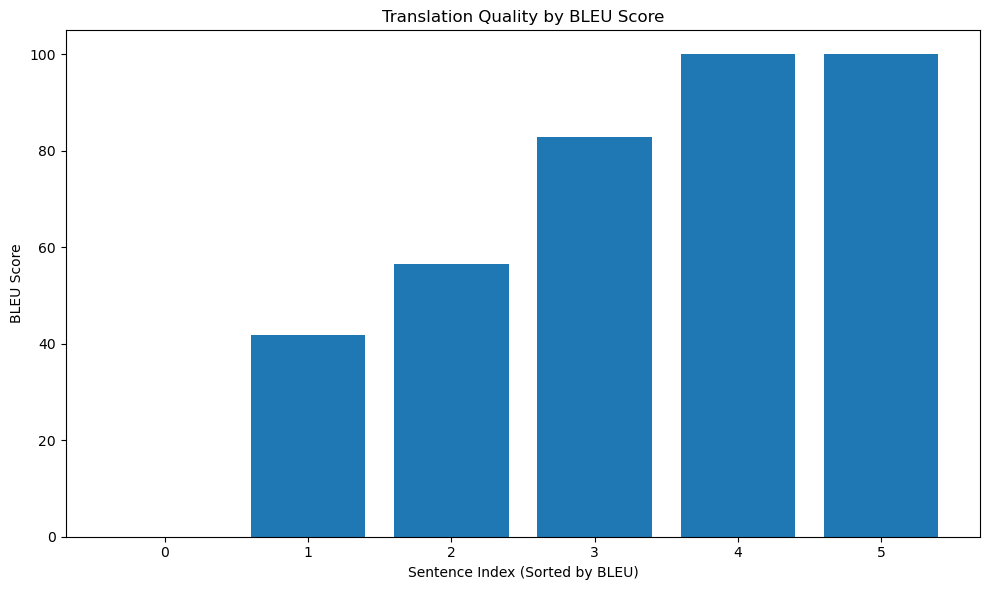

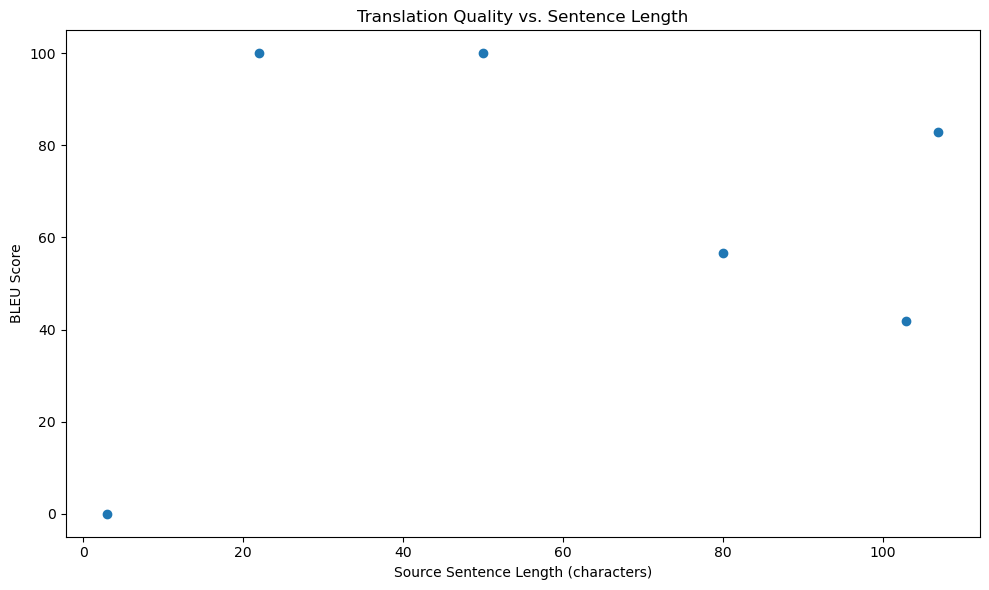

In [17]:
print("\n\n--- Error Analysis ---")


# Test on a mix of simple and complex sentences
test_sentences_for_analysis = [
    "Hi.",
    "This is a simple test.",
    "I don't think this will be difficult to translate.",
    "The cat jumped over the lazy dog while the sun was setting behind the mountains.",
    "Neural machine translation has revolutionized language processing by utilizing deep learning architectures.",
    "The model might struggle with technical terms like eigen decomposition and hyperparameter optimization."
]

# Reference translations (you can add these if you have them)
reference_translations = [
    "Bonjour.",
    "C'est un test simple.",
    "Je ne pense pas que ce sera difficile à traduire.",
    "Le chat a sauté par-dessus le chien paresseux pendant que le soleil se couchait derrière les montagnes.",
    "La traduction automatique neuronale a révolutionné le traitement des langues en utilisant des architectures d'apprentissage profond.",
    "Le modèle pourrait avoir des difficultés avec des termes techniques comme la décomposition propre et l'optimisation des hyperparamètres."
]

# Run the analysis
error_analysis_results = analyze_translation_errors(model, tokenizer, test_sentences_for_analysis, reference_translations)

# Display results as a table
error_df = pd.DataFrame(error_analysis_results)
print("Translation Error Analysis:")
display(error_df)

# Categorize errors (basic analysis)
print("\nError Categories:")
categories = {
    "Perfect/Near Perfect": 0,
    "Minor Issues": 0,
    "Major Errors": 0,
    "Completely Wrong": 0
}

# Threshold values for categorization (can be adjusted)
for result in error_analysis_results:
    if result["bleu"] is None:
        continue

    if result["bleu"] > 80:
        categories["Perfect/Near Perfect"] += 1
    elif result["bleu"] > 50:
        categories["Minor Issues"] += 1
    elif result["bleu"] > 20:
        categories["Major Errors"] += 1
    else:
        categories["Completely Wrong"] += 1

# Display error categories
for category, count in categories.items():
    print(f"{category}: {count}")

# Optional: Visualize the results
try:
    import matplotlib.pyplot as plt

    # Sort by BLEU score to identify patterns
    error_df_sorted = error_df.sort_values(by="bleu")

    # Plot BLEU scores
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(error_df_sorted)), error_df_sorted["bleu"])
    plt.xlabel("Sentence Index (Sorted by BLEU)")
    plt.ylabel("BLEU Score")
    plt.title("Translation Quality by BLEU Score")
    plt.tight_layout()
    plt.show()

    # Plot sentence length vs. BLEU score
    plt.figure(figsize=(10, 6))
    error_df["source_length"] = error_df["source"].apply(len)
    plt.scatter(error_df["source_length"], error_df["bleu"])
    plt.xlabel("Source Sentence Length (characters)")
    plt.ylabel("BLEU Score")
    plt.title("Translation Quality vs. Sentence Length")
    plt.tight_layout()
    plt.show()

except ImportError:
    print("Matplotlib not available for visualization")